# Irrigation and Rainfall

The goal of this study is to optimize the schedule of irrigation to maximize biomass production under the assumption of having a certain amount or Quota of water and taking into consideration rainfall.

We consider the following crop irrigation model, where $B(t)$ stands for crop biomass at time t and $S(t)$ stands for relative sol humidity in the root zone:

$$ \dot S = k_1(-\phi(t)K_S(S)-(1-\phi(t))K_R(S)+k_2u(t) + p(t))$$ 
$$ \dot B = \phi(t)K_S(S) $$

with the initial conditions: $S(0)=S_0>S_*$ and $B(0)=B_0>0$ and $p$ is the intensity of rainfall.

$Q_{rain} = \frac{1}{k2} \int_{0}^{T} p(t) dt$

The piecewise linear non decreasing from $[0,1]$ to $[0,1]$ functions $K_R$ and $K_S$ are defined thanks to the key constants : $S_w$ which represents the plant wilting point, $S_h$ which represents the hydroscopic point and $S_*$, the minimal threshold on the soil humidity that gives the best biomass production: 

$K_S(S)$=$\begin{cases}
0 if S \in [0,S_w] \\
\frac{S-S_w}{S_*-S_w} if S \in [0,S_w] \\
1 if S \in [S_*,1]
\end{cases}$


$K_R(S)$=$\begin{cases}
0 if S \in [0,S_h] \\
\frac{S-S_h}{1-S_h} if S \in [S_h,1]
\end{cases}$



where 0 < $S_h$ < $S_w$ < $S_*$ < 1

Therefore, our optimisation problem is:

$$max_{u(.)} \int_0^T \phi(t)K_S(S(t))$$

where $\dot V = u(t)$ and $V(0)=0$ and the target : $V(T)=\bar V=\frac{\bar Q}{F_{max}}$.

[Thumbnail](image.jpg)

In [37]:
## Imports
import os, subprocess
import numpy as np
import matplotlib.pyplot as plt
import bocop

### Defining rainfall : a piecewise continuous function on the interval $[0,T]$

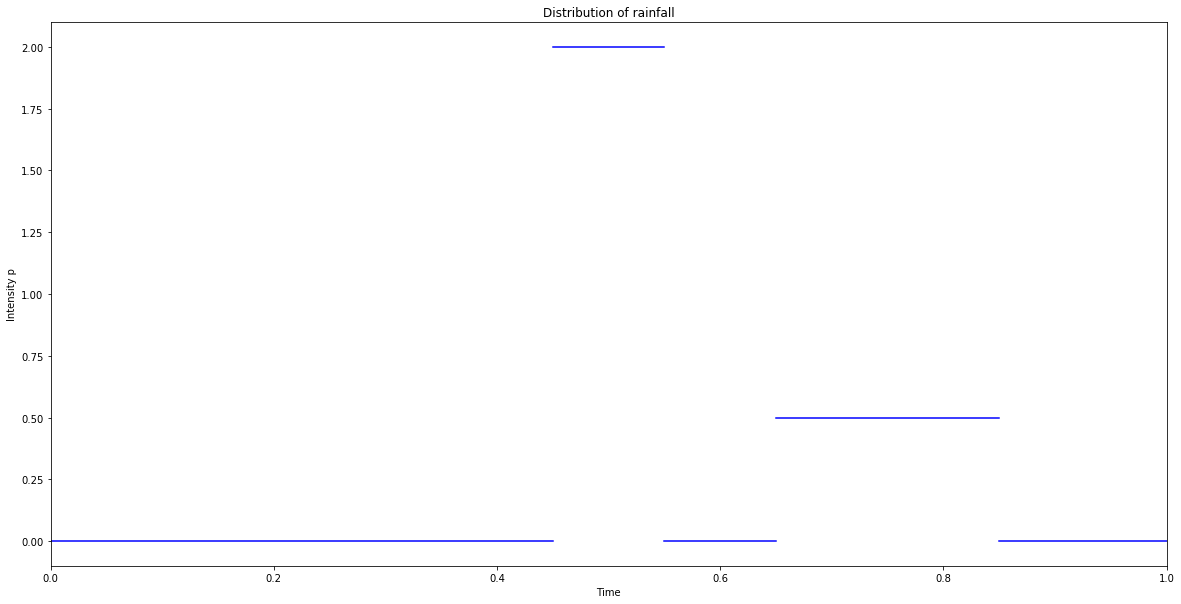

In [38]:
T_real = [0.45,0.55,0.65,0.85] ## The intervals [T_real[2*i],T_real[2*i+1]] are the intervals where we have rainfall in real life.
T = [0.5,0.6,0.7,0.85] ## T[i] is the time where we launch a new simulation that corresponds to T_real[i]
A = [2,0.5]     ## A[i] is the intensity of rainfall during the period [T[2*i],T[2*i+1]]
time_steps = 500

plt.figure(99, figsize=(20,10))

plt.plot([0,T_real[0]],[0,0],color="blue")
for i in range(len(A)):
    plt.plot([T_real[2*i],T_real[2*i+1]],[A[i],A[i]],color="blue")
    if i != len(A)-1:
        plt.plot([T_real[2*i+1],T_real[2*(i+1)]],[0,0],color="blue")
plt.plot([T_real[-1],1],[0,0],color="blue")
plt.title("Distribution of rainfall")
plt.ylabel("Intensity p")
plt.xlabel("Time")
plt.xlim(0,1)
plt.show()



### Problem without rainfall

In [39]:
def deleteRain(file):
    f = open(file,"r")
    lines = f.readlines()
    f.close()
    index1 = [index for index in range(len(lines)) if lines[index].startswith("// Start Rain.")]
    index2 = [index for index in range(len(lines)) if lines[index].startswith("// End Rain.")]
    lines1 = lines[:index1[0]+1]
    lines2 = lines[index2[0]:]
    f = open(file,"w")
    f.writelines(lines1)
    f.writelines(lines2)
    f.close()
    
deleteRain("problem.cpp")
sp0 = subprocess.Popen(['python problem_without_rainfall.py'], shell=True, stdout=subprocess.DEVNULL)
sp0.wait()

solution = bocop.readSolution("problem.sol",verbose=0)
t_normal = solution.time_steps
s_normal = solution.state[0]
b_normal = solution.state[1]
v_normal = solution.state[2]
u_normal = solution.control[0]
B_normal = abs(solution.objective)

print("(Problem without rainfall) Biomass is : ",B_normal)

(Problem without rainfall) Biomass is :  0.390229631725754


### Problem with rainfall known at first

In [40]:
def updateRain(file,T,A):
    
    f = open(file,"r")
    lines = f.readlines()
    f.close()
    index1 = [index for index in range(len(lines)) if lines[index].startswith("// Start Rain.")]
    index2 = [index for index in range(len(lines)) if lines[index].startswith("// End Rain.")]
    lines1 = lines[:index1[0]+1]
    lines2 = lines[index2[0]:]
    
    f = open(file,"w")
    f.writelines(lines1)
    
    for a in range(len(A)):
        line = "if (time >=",str(T[2*a])," && time<=",str(T[2*a+1]),") { p=",str(A[a]),";}\n"
        f.writelines(line)
        
    f.writelines(lines2)
    f.close()

updateRain("problem.cpp",T_real,A)
sp1 = subprocess.Popen(['python problem_with_rainfall.py'], shell=True, stdout=subprocess.DEVNULL)
sp1.wait()
solution = bocop.readSolution("problem.sol",verbose=0)
time = solution.time_steps
s = solution.state[0]
b = solution.state[1]
v = solution.state[2]
u = solution.control[0]
B = abs(solution.objective)

print("(Problem with rainfall known at first) Biomass is : ",B)

(Problem with rainfall known at first) Biomass is :  0.500459878243863


### Problem without rainfall VS Problem with rainfall known at first

(Problem without rainfall) Biomass is :  0.390229631725754
(Problem with rainfall known at first) Biomass is :  0.500459878243863


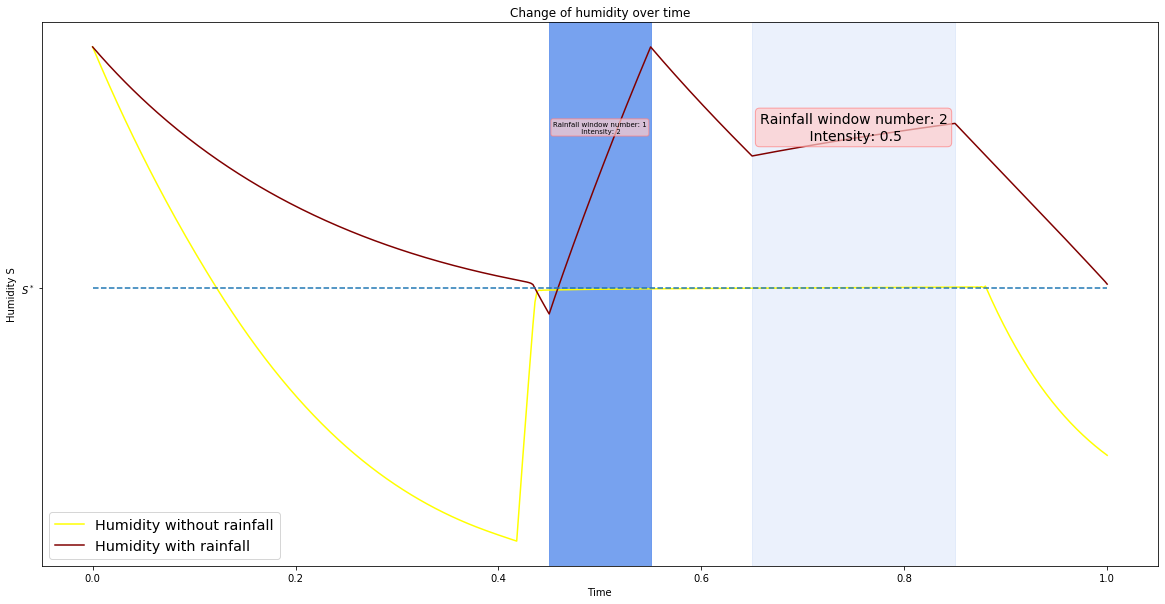

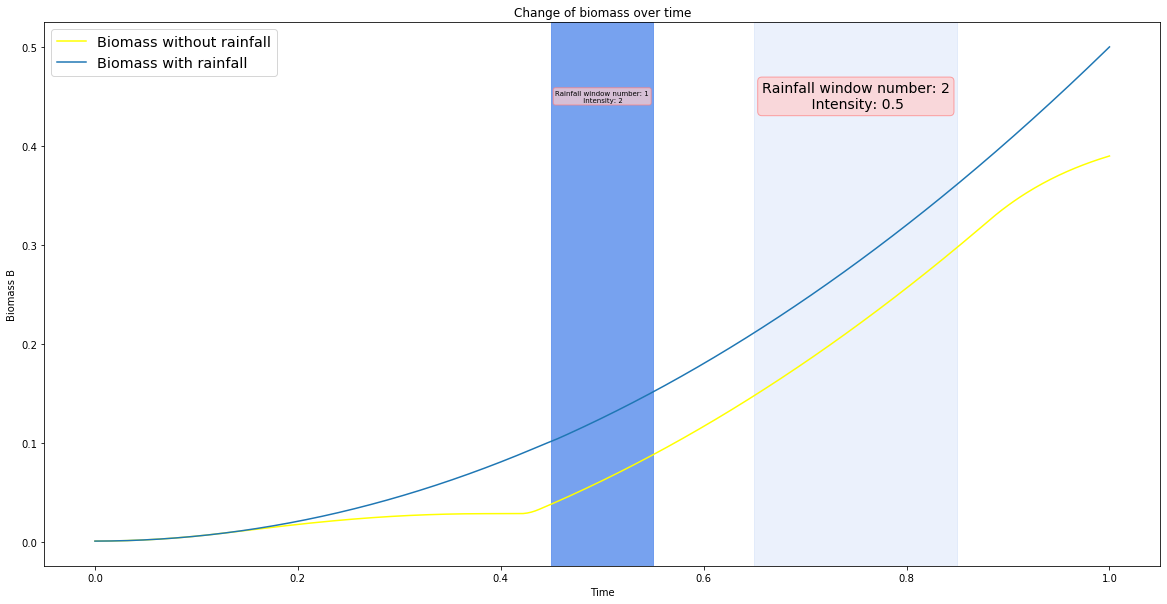

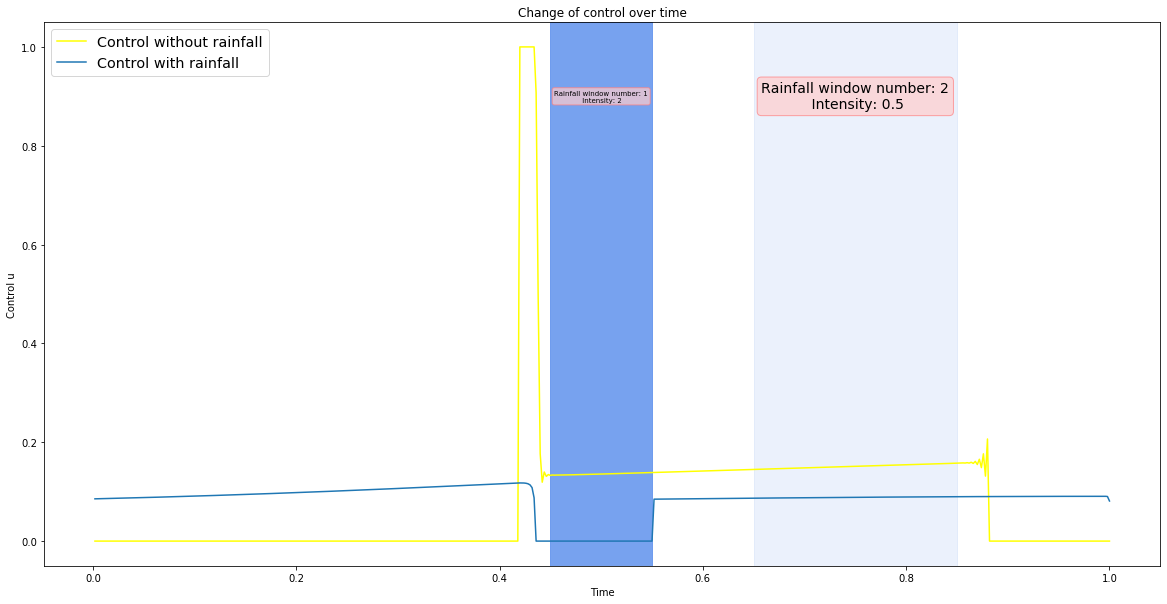

In [41]:
print("(Problem without rainfall) Biomass is : ",B_normal)
print("(Problem with rainfall known at first) Biomass is : ",B)

plt.figure(0, figsize=(20,10))

## Plotting humidity S 
plt.plot(t_normal,s_normal,color="yellow")
plt.plot(time,s,color="maroon")
plt.legend(['Humidity without rainfall','Humidity with rainfall'],fontsize="x-large")
plt.plot([0,1],[0.7,0.7],linestyle='--')
plt.yticks([0.7], ['$S^*$'])
plt.ylabel("Humidity S")
plt.xlabel("Time")
plt.title("Change of humidity over time")
max_A = max(A)
min_A = min(A)
for k in range(len(A)):
    plt.axvspan(T_real[2*k], T_real[2*k+1], color="cornflowerblue", alpha=(A[k]-min_A/2)/max_A)
    text = "Rainfall window number: "+str(k+1)+"\n Intensity: "+str(A[k])
    plt.text((T_real[2*k]+T_real[2*k+1])/2, 0.9,text , size=70*(T_real[2*k+1]-T_real[2*k]),
         ha="center", va="center",
         bbox=dict(boxstyle="round",
                   ec=(1., 0.5, 0.5),
                   fc=(1., 0.8, 0.8),
                   alpha = 0.7)
         )

plt.figure(1, figsize=(20,10))

## Plotting biomass b
plt.plot(t_normal,b_normal,color="yellow")
plt.plot(time,b)
plt.legend(['Biomass without rainfall','Biomass with rainfall'],fontsize="x-large")
plt.ylabel("Biomass B")
plt.xlabel("Time")
plt.title("Change of biomass over time")
for k in range(len(A)):
    plt.axvspan(T_real[2*k], T_real[2*k+1], color="cornflowerblue", alpha=(A[k]-min_A/2)/max_A)
    text = "Rainfall window number: "+str(k+1)+"\n Intensity: "+str(A[k])
    plt.text((T_real[2*k]+T_real[2*k+1])/2, b[-1] - 0.05,text , size=70*(T_real[2*k+1]-T_real[2*k]),
         ha="center", va="center",
         bbox=dict(boxstyle="round",
                   ec=(1., 0.5, 0.5),
                   fc=(1., 0.8, 0.8),
                   alpha = 0.7)
         )
plt.show()


plt.figure(2, figsize=(20,10))

## Plotting control u
plt.plot(t_normal[1:],u_normal,color="yellow")
plt.plot(time[1:],u)
plt.legend(['Control without rainfall','Control with rainfall'],fontsize="x-large")
plt.ylabel("Control u")
plt.xlabel("Time")
plt.title("Change of control over time")
for k in range(len(A)):
    plt.axvspan(T_real[2*k], T_real[2*k+1], color="cornflowerblue", alpha=(A[k]-min_A/2)/max_A)
    text = "Rainfall window number: "+str(k+1)+"\n Intensity: "+str(A[k])
    plt.text((T_real[2*k]+T_real[2*k+1])/2, 0.9,text , size=70*(T_real[2*k+1]-T_real[2*k]),
         ha="center", va="center",
         bbox=dict(boxstyle="round",
                   ec=(1., 0.5, 0.5),
                   fc=(1., 0.8, 0.8),
                   alpha = 0.7)
         )
plt.show()


### Problem with adaptive solving

In [42]:
T2 = [0]+T+[1]
T_real2 = T_real.copy()
A2 = A.copy()
A3 = A.copy()
rainfall = False
tol_t = 1e-2
T_save,S_save,B_save,V_save,U_save = [],[],[],[],[]
t_temp,s_temp,b_temp,v_temp,u_temp,time_steps_done = 0,1,0.001,0,0.5,0
for t in T2[1:]:
    if rainfall:
        print('Solving for interval [',t_temp,',',t,'] \n')
        os.chdir('./adaptive_solving/with_rain')
        
        ## Modify problem.def
        bocop.setInDef("initial.time",t_temp)

        bocop.setInDef("boundarycond.0.lowerbound",s_temp)
        bocop.setInDef("boundarycond.0.upperbound",s_temp)
        bocop.setInDef("state.0.init",s_temp)

        bocop.setInDef("boundarycond.1.lowerbound",b_temp)
        bocop.setInDef("boundarycond.1.upperbound",b_temp)
        bocop.setInDef("state.1.init",b_temp)

        bocop.setInDef("boundarycond.2.lowerbound",v_temp)
        bocop.setInDef("boundarycond.2.upperbound",v_temp)
        bocop.setInDef("state.2.init",v_temp)

        bocop.setInDef("control.0.init",u_temp)

        bocop.setInDef("time.steps",time_steps - time_steps_done)

        
        
        ## Modify problem.cpp
        Rain_interval = [T_real2.pop(0),T_real2.pop(0)]
        updateRain("problem.cpp",Rain_interval,[A3.pop(0)])
        
        
        f = open("problem.cpp","r")
        lines = f.readlines()
        f.close()
        index1 = [index for index in range(len(lines)) if lines[index].startswith("state_dynamics[0]")]
        lines1 = lines[:index1[0]]
        lines2 = lines[index1[0]+1:]
        f = open("problem.cpp","w")
        f.writelines(lines1)
        line = "state_dynamics[0] = k1*(-KS*phi-KR*(1-phi)+k2*Fmax*u +p);\n"
        f.writelines(line)
        f.writelines(lines2)
        f.close()
        
        sp2 = subprocess.Popen(['python rain.py'], shell=True, stdout=subprocess.DEVNULL)
        sp2.wait()
        solution = bocop.readSolution("problem.sol",verbose=0)
        
        t_for_index = solution.time_steps
        index = np.where(abs(t-t_for_index) <= tol_t)[0][-1]
        
        S_save.append(solution.state[0][:index])
        B_save.append(solution.state[1][:index])
        V_save.append(solution.state[2][:index])
        U_save.append(solution.control[0][:index])
        
        t_temp,s_temp,b_temp,v_temp,u_temp = t,solution.state[0][index],solution.state[1][index],solution.state[2][index],solution.control[0][index-1]
        time_steps_done += index
        
        rainfall = False 
        os.chdir('../..')
    else:
        print('Solving for interval [',t_temp,',',t,'] \n')
        os.chdir('./adaptive_solving/without_rain')
        
        ## Modify problem.def
        bocop.setInDef("initial.time",t_temp)

        bocop.setInDef("boundarycond.0.lowerbound",s_temp)
        bocop.setInDef("boundarycond.0.upperbound",s_temp)
        bocop.setInDef("state.0.init",s_temp)

        bocop.setInDef("boundarycond.1.lowerbound",b_temp)
        bocop.setInDef("boundarycond.1.upperbound",b_temp)
        bocop.setInDef("state.1.init",b_temp)

        bocop.setInDef("boundarycond.2.lowerbound",v_temp)
        bocop.setInDef("boundarycond.2.upperbound",v_temp)
        bocop.setInDef("state.2.init",v_temp)

        bocop.setInDef("control.0.init",u_temp)

        bocop.setInDef("time.steps",time_steps - time_steps_done)

        sp3 = subprocess.Popen(['python problem_without_rainfall.py'], shell=True, stdout=subprocess.DEVNULL)
        sp3.wait()
        solution = bocop.readSolution("problem.sol",verbose=0)
        
        t_for_index = solution.time_steps
        index = np.where(abs(t-t_for_index) <= tol_t)[0][-1]
        
        S_save.append(solution.state[0][:index])
        B_save.append(solution.state[1][:index])
        V_save.append(solution.state[2][:index])
        U_save.append(solution.control[0][:index])
        
        t_temp,s_temp,b_temp,v_temp,u_temp = t,solution.state[0][index],solution.state[1][index],solution.state[2][index],solution.control[0][index-1]
        time_steps_done += index
        
        rainfall = True
        os.chdir('../..')

S_final = np.concatenate(S_save)
B_final = np.concatenate(B_save)
V_final = np.concatenate(V_save)
U_final = np.concatenate(U_save)   

Solving for interval [ 0 , 0.5 ] 

Solving for interval [ 0.5 , 0.6 ] 

Solving for interval [ 0.6 , 0.7 ] 

Solving for interval [ 0.7 , 0.85 ] 

Solving for interval [ 0.85 , 1 ] 



### Problem without rainfall VS Problem with rainfall known at first VS Problem with adaptive solving

(Problem without rainfall) Biomass is :  0.390229631725754
(Problem with rainfall known at first) Biomass is :  0.500459878243863
(Problem with adaptive solving) Biomass is :  0.457872711426639


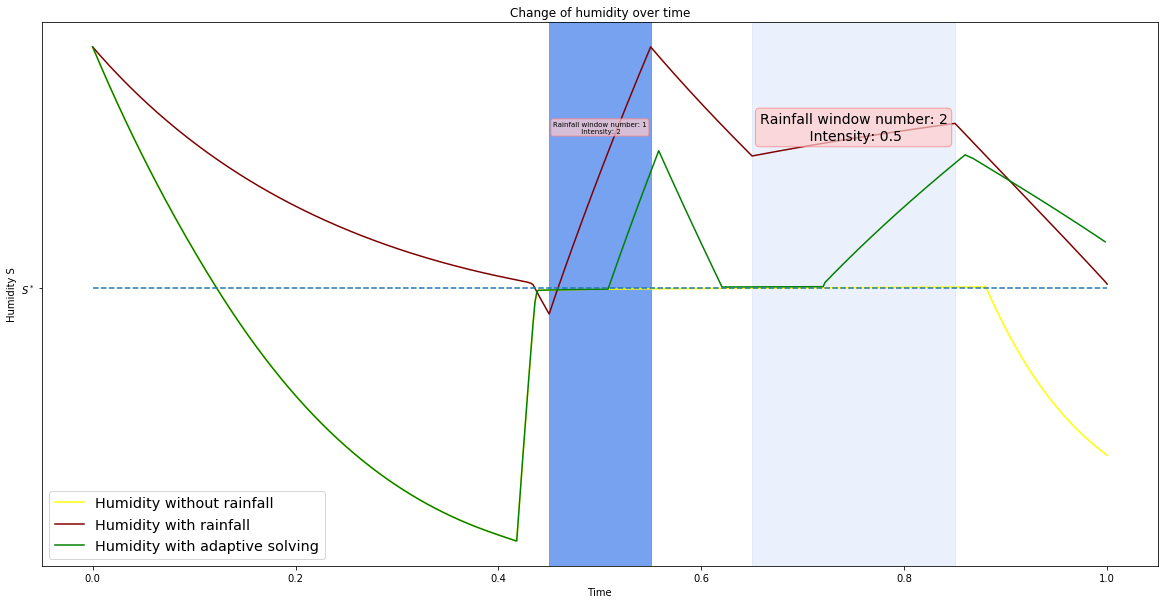

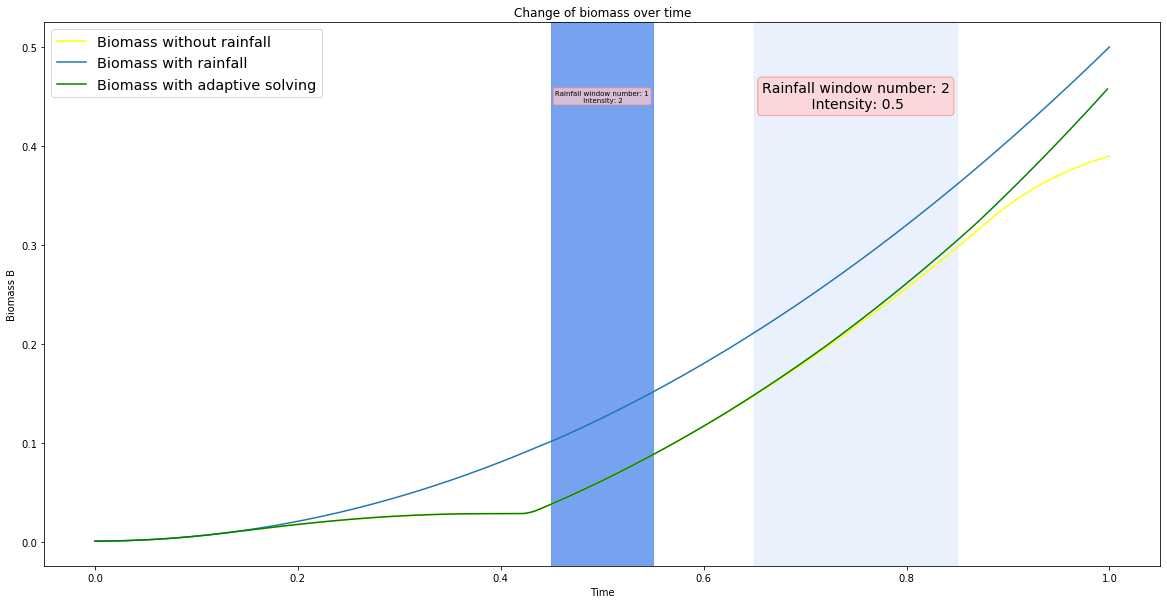

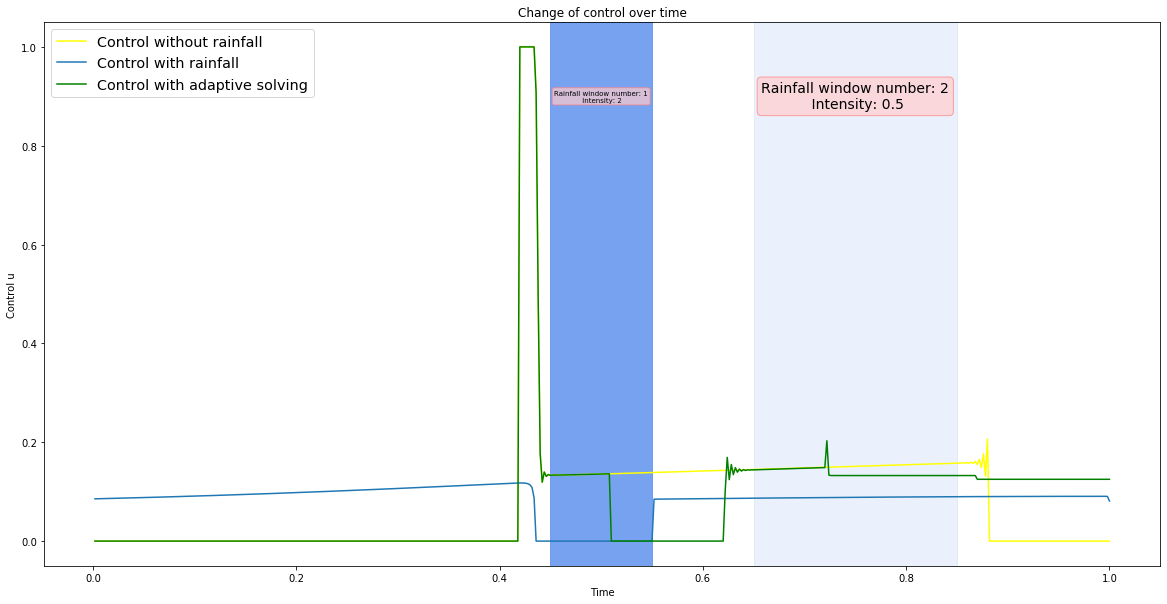

In [43]:
print("(Problem without rainfall) Biomass is : ",B_normal)
print("(Problem with rainfall known at first) Biomass is : ",B)
print("(Problem with adaptive solving) Biomass is : ",B_final[-1])


plt.figure(3, figsize=(20,10))

## Plotting humidity S 
plt.plot(t_normal,s_normal,color="yellow")
plt.plot(t_normal,s,color="maroon")
plt.plot(t_normal[:-1],S_final,color="green")
plt.legend(['Humidity without rainfall','Humidity with rainfall','Humidity with adaptive solving'],fontsize="x-large")
plt.plot([0,1],[0.7,0.7],linestyle='--')
plt.yticks([0.7], ['$S^*$'])
plt.ylabel("Humidity S")
plt.xlabel("Time")
plt.title("Change of humidity over time")
max_A = max(A)
min_A = min(A)
for k in range(len(A)):
    plt.axvspan(T_real[2*k], T_real[2*k+1], color="cornflowerblue", alpha=(A[k]-min_A/2)/max_A)
    text = "Rainfall window number: "+str(k+1)+"\n Intensity: "+str(A[k])
    plt.text((T_real[2*k]+T_real[2*k+1])/2, 0.9,text , size=70*(T_real[2*k+1]-T_real[2*k]),
         ha="center", va="center",
         bbox=dict(boxstyle="round",
                   ec=(1., 0.5, 0.5),
                   fc=(1., 0.8, 0.8),
                   alpha = 0.7)
         )
plt.figure(4, figsize=(20,10))

## Plotting biomass b
plt.plot(t_normal,b_normal,color="yellow")
plt.plot(t_normal,b)
plt.plot(t_normal[:-1],B_final,color="green")
for k in range(len(A)):
    plt.axvspan(T_real[2*k], T_real[2*k+1], color="cornflowerblue", alpha=(A[k]-min_A/2)/max_A)
    text = "Rainfall window number: "+str(k+1)+"\n Intensity: "+str(A[k])
    plt.text((T_real[2*k]+T_real[2*k+1])/2, b[-1] - 0.05,text , size=70*(T_real[2*k+1]-T_real[2*k]),
         ha="center", va="center",
         bbox=dict(boxstyle="round",
                   ec=(1., 0.5, 0.5),
                   fc=(1., 0.8, 0.8),
                   alpha = 0.7)
         )
plt.legend(['Biomass without rainfall','Biomass with rainfall','Biomass with adaptive solving'],fontsize="x-large")
plt.ylabel("Biomass B")
plt.xlabel("Time")
plt.title("Change of biomass over time")
plt.show()


plt.figure(5, figsize=(20,10))

## Plotting control u
plt.plot(t_normal[1:],u_normal,color="yellow")
plt.plot(t_normal[1:],u)
plt.plot(t_normal[1:],U_final,color="green")
for k in range(len(A)):
    plt.axvspan(T_real[2*k], T_real[2*k+1], color="cornflowerblue", alpha=(A[k]-min_A/2)/max_A)
    text = "Rainfall window number: "+str(k+1)+"\n Intensity: "+str(A[k])
    plt.text((T_real[2*k]+T_real[2*k+1])/2, 0.9,text , size=70*(T_real[2*k+1]-T_real[2*k]),
         ha="center", va="center",
         bbox=dict(boxstyle="round",
                   ec=(1., 0.5, 0.5),
                   fc=(1., 0.8, 0.8),
                   alpha = 0.7)
         )
plt.legend(['Control without rainfall','Control with rainfall','Control with adaptive solving'],fontsize="x-large")
plt.ylabel("Control u")
plt.xlabel("Time")
plt.title("Change of control over time")
plt.show()